In [ ]:
import numpy as np 
import pandas as pd 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pre = pd.read_csv('/content/drive/MyDrive/Dataset/subset_googledataset.csv')

In [ ]:
pre.head()

,original,compressed
0,Serge Ibaka -- the Oklahoma City Thunder forwa...,Serge Ibaka has been granted Spanish citizensh...
1,MILAN -Catania held Roma to a 1-1 draw in Seri...,Catania held Roma to a 1 1 draw in Serie A.
2,"State Street Corporation, a provider of invest...","State Street Corporation, has launched a new i..."
3,"Massey Energy, the fourth largest coal company...","Massey Energy, the coal company, could have it..."
4,"Foundation for MetroWest has awarded $55,000 i...","Foundation for MetroWest has awarded $ 55,000 ..."


In [ ]:
pre['original'][:10]

0    Serge Ibaka -- the Oklahoma City Thunder forwa...
1    MILAN -Catania held Roma to a 1-1 draw in Seri...
2    State Street Corporation, a provider of invest...
3    Massey Energy, the fourth largest coal company...
4    Foundation for MetroWest has awarded $55,000 i...
5    Wong won't rule out super raid Updated: 08:17,...
6    TINY 'robots' that can be dropped into an indu...
7    Jordan and South Korea have pledged to coopera...
8    Just after the Fourth of July holiday, and onl...
9    Tim Cowlishaw made a bad joke and now the MMA ...
Name: original, dtype: object

In [ ]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [ ]:
brief_cleaning1 = text_strip(pre['original'])
brief_cleaning2 = text_strip(pre['compressed'])

In [ ]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.34 mins


In [ ]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.57 mins


In [ ]:
text[0]

'serge ibaka the oklahoma city thunder forward who was born in the congo but played in spain has been granted spanish citizenship and will play for the country in eurobasket this summer the event where spots in the 2012 olympics will be decided.'

In [ ]:
summary[0]

'_START_ serge ibaka has been granted spanish citizenship and will play in eurobasket. _END_'

In [ ]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

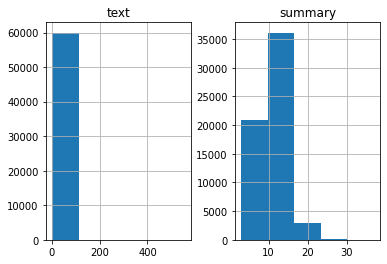

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=25):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9992500249991667


In [ ]:
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9992333588880371


In [ ]:
max_text_len=100
max_summary_len=25

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre.head(2)

,text,summary
0,serge ibaka the oklahoma city thunder forward ...,_START_ serge ibaka has been granted spanish c...
1,milan -catania held roma to 1-1 draw in serie ...,_START_ catania held roma to draw in serie a. ...


In [ ]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
post_pre.head(2)

,text,summary
0,serge ibaka the oklahoma city thunder forward ...,sostok _START_ serge ibaka has been granted sp...
1,milan -catania held roma to 1-1 draw in serie ...,sostok _START_ catania held roma to draw in se...


In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.66591265889026
Total Coverage of rare words: 4.340942820660505


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 18563


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.97253106605625
Total Coverage of rare words: 7.158811481255384


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 8421


In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

#encoder lstm 4
encoder_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 18563
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     3712600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
211/211 [==============================] - 550s 3s/step - loss: 2.7432 - val_loss: 2.3595
Epoch 2/5
211/211 [==============================] - 516s 2s/step - loss: 2.3229 - val_loss: 2.2105
Epoch 3/5
211/211 [==============================] - 524s 2s/step - loss: 2.1978 - val_loss: 2.1259
Epoch 4/5
211/211 [==============================] - 519s 2s/step - loss: 2.1252 - val_loss: 2.0787
Epoch 5/5
211/211 [==============================] - 522s 2s/step - loss: 2.0692 - val_loss: 2.0369


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
211/211 [==============================] - 520s 2s/step - loss: 2.0146 - val_loss: 1.9977
Epoch 2/5
211/211 [==============================] - 516s 2s/step - loss: 1.9668 - val_loss: 1.9637
Epoch 3/5
211/211 [==============================] - 523s 2s/step - loss: 1.9167 - val_loss: 1.9286
Epoch 4/5
211/211 [==============================] - 532s 3s/step - loss: 1.8743 - val_loss: 1.8995
Epoch 5/5
211/211 [==============================] - 524s 2s/step - loss: 1.8368 - val_loss: 1.8797


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
211/211 [==============================] - 528s 3s/step - loss: 1.8000 - val_loss: 1.8553
Epoch 2/5
211/211 [==============================] - 524s 2s/step - loss: 1.7659 - val_loss: 1.8361
Epoch 3/5
211/211 [==============================] - 515s 2s/step - loss: 1.7322 - val_loss: 1.8190
Epoch 4/5
211/211 [==============================] - 510s 2s/step - loss: 1.7009 - val_loss: 1.7979
Epoch 5/5
211/211 [==============================] - 521s 2s/step - loss: 1.6678 - val_loss: 1.7766


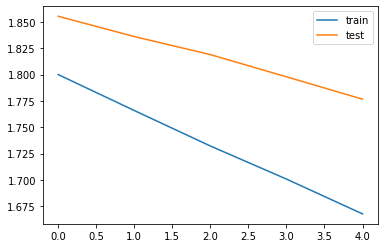

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("efficient.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("efficient.h5")
print("Saved model 25 to disk")

Saved model 25 to disk


In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: the obama administration on tuesday lifted its deepwater drilling ban six weeks ahead of schedule stating that new rules are sufficient to protect against future oil 
Original summary: start the obama administration lifted its drilling ban end 
Predicted summary:  start the us government approved the first time to the us end


Review: minimum monthly wage in latvia will be raised to 180 starting january 2009 the government decided today 
Original summary: start minimum monthly wage in will be raised to 180 starting january 2009 end 
Predicted summary:  start will be closed end


Review: an alligator spent tuesday night in the cells of police station in south eastern france after local woman found it on road outside restaurant 
Original summary: start an spent night in the cells found end 
Predicted summary:  start an man pleaded guilty to charges end


Review: the london based money manager which has been among the most investors in the irish stock market for the past two decad

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("summary123.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("sumarys123.h5")
print("Saved model 25 to disk")

Saved model 25 to disk


In [ ]:
!pip install rouge_score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
goldstandard = []
summ = []

for i in range(0, 100):
    goldstandard.append(seq2summary(y_tr[i]))

for i in range(0, 100):
    summ.append(decode_sequence(x_tr[i].reshape(1, max_text_len)))

In [ ]:
GOLD = []
for i in goldstandard:
    GOLD.append(i.split())

SUMM = []
for i in summ:
    SUMM.append(i.split())

In [ ]:
import nltk 
nltk.translate.bleu_score.corpus_bleu(GOLD, SUMM)

0.3943493429230277

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge 
rouge = Rouge()
for i, j in zip(goldstandard, summ):
    print("Original summary:",i)
    print("Predicted summary:",j)
    scores = rouge.get_scores(i, j)
    print(scores)
    print('s\n')

Original summary: start the obama administration lifted its drilling ban end 
Predicted summary:  start the us government approved the first time to the us end
[{'rouge-1': {'r': 0.3333333333333333, 'p': 0.3333333333333333, 'f': 0.3333333283333334}, 'rouge-2': {'r': 0.1, 'p': 0.125, 'f': 0.11111110617283973}, 'rouge-l': {'r': 0.3333333333333333, 'p': 0.3333333333333333, 'f': 0.3333333283333334}}]
s

Original summary: start minimum monthly wage in will be raised to 180 starting january 2009 end 
Predicted summary:  start will be closed end
[{'rouge-1': {'r': 0.8, 'p': 0.2857142857142857, 'f': 0.421052627700831}, 'rouge-2': {'r': 0.25, 'p': 0.07692307692307693, 'f': 0.11764705522491362}, 'rouge-l': {'r': 0.8, 'p': 0.2857142857142857, 'f': 0.421052627700831}}]
s

Original summary: start an spent night in the cells found end 
Predicted summary:  start an man pleaded guilty to charges end
[{'rouge-1': {'r': 0.375, 'p': 0.3333333333333333, 'f': 0.35294117148788934}, 'rouge-2': {'r': 0.142857

In [ ]:
from rouge import Rouge 

In [ ]:
hypothesis = "talk to your friends about your feelings talk to therapist "
reference = "problem solve ask for support prioritize self care take break engage in therapy help others"

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
